In [1]:
###### %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# convolutional autoencoder in keras

import os
#os.environ["KERAS_BACKEND"] = "tensorflow"

from __future__ import print_function
from keras.models import Model
from keras.layers import *
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K

import matplotlib.pyplot as plt
# %matplotlib inline

from keras.datasets import mnist 

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

from PIL import Image

K.set_learning_phase(1)
warnings.filterwarnings('ignore')

# utility function for showing images
def show_imgs(x_test, decoded_imgs, n=4):
    plt.figure(figsize=(20, 10))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[i].reshape(size,size,3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            ax = plt.subplot(2, n, i+ 1 +n)
            plt.imshow(decoded_imgs[i].reshape(size,size,3))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()
    
def show_imgs_gray_out(x_test, decoded_imgs, n=4):
    plt.figure(figsize=(20, 10))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[i].reshape(size,size,3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            ax = plt.subplot(2, n, i+ 1 +n)
            plt.imshow(decoded_imgs[i].reshape(size,size))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()
    
def show_hidden(x_test, encoded_imgs, n=10):
    
    en0=np.zeros((encoded_imgs.shape[0],encoded_imgs.shape[1],encoded_imgs.shape[2]))
    en1=np.zeros((encoded_imgs.shape[0],encoded_imgs.shape[1],encoded_imgs.shape[2]))
    en2=np.zeros((encoded_imgs.shape[0],encoded_imgs.shape[1],encoded_imgs.shape[2]))
    en3=np.zeros((encoded_imgs.shape[0],encoded_imgs.shape[1],encoded_imgs.shape[2]))

    for i in range(encoded_imgs.shape[0]):
        for j in range(encoded_imgs.shape[1]):
            for k in range(encoded_imgs.shape[2]):
                en0[i][j][k]=encoded_imgs[i][j][k][0]
                en1[i][j][k]=encoded_imgs[i][j][k][1]
                en2[i][j][k]=encoded_imgs[i][j][k][2]
                en3[i][j][k]=encoded_imgs[i][j][k][3]
    
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(5, n, i+1)
        plt.imshow(x_test[i].reshape(size,size,3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            ax = plt.subplot(5, n, i+ 1 +n)
            plt.imshow(en0[i].reshape(int(size/2),int(size/2)))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            ax = plt.subplot(5, n, i+ 1 +2*n)
            plt.imshow(en1[i].reshape(int(size/2),int(size/2)))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            ax = plt.subplot(5, n, i+ 1 +3*n)
            plt.imshow(en2[i].reshape(int(size/2),int(size/2)))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            ax = plt.subplot(5, n, i+ 1 +4*n)
            plt.imshow(en3[i].reshape(int(size/2),int(size/2)))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

def getMaxGrads(input_set, model, layer_name, nof):
    
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    
    out = np.zeros((len(input_set),len(input_set[0]),len(input_set[0][0])))

    for i in range(nof):
        filter_index = i  # can be any integer from 0 to 511, as there are 512 filters in that layer

        layer_output = layer_dict[layer_name].output
        loss = K.mean(layer_output[:, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        #normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)  ### normalize? ... later

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        it = iterate([input_set])
        
        len1=len(out)
        len2=len(out[0])
        len3=len(out[0][0])
        
        for j in range(len1):
            for k in range(len2):
                for l in range(len3):
                    if np.mean(abs(it[1][j][k][l])) > out[j][k][l]:   #abs()?
                    #if np.mean(it[1][j][k][l]) > out[j][k][l]:   #abs()?
                        out[j][k][l]=np.mean(it[1][j][k][l])
                        
        return out
    
def lk_relu(x):
    return K.relu(x, alpha=0.01)

print("Starting")

/home/hoffmann/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Starting


13520
0
676
Train Data done
Test Data done


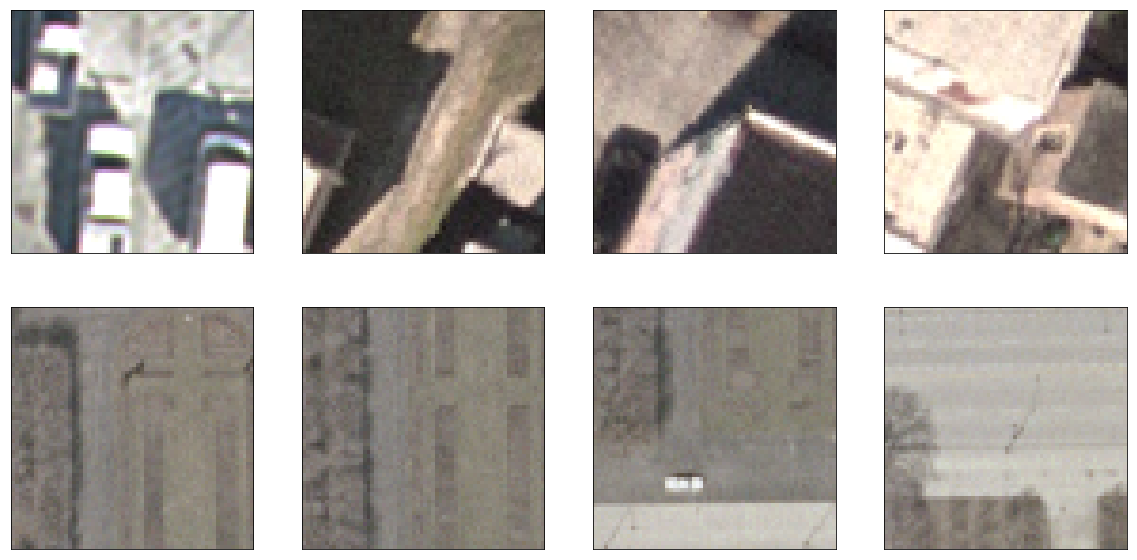

In [2]:
### Create input

fullsize=256
size=64
cuts=fullsize/size

train_path = "/home/hoffmann/MA/OIRDS_v1_0/train/train/"
test_path = "/home/hoffmann/MA/OIRDS_v1_0/test/test/"

def loadpatches(train_path, test_path, size):

    train_batches = []
    listing = os.listdir(train_path) 
    for file in listing:
        im = Image.open(train_path + file) 
        sx,sy,sz=im.shape()
        x_cuts=sx/size
        y_cuts=sy/size
        z_cuts=sz/size
        x_rest=sx/size
        y_rest=sy/size
        z_rest=sz/size
        for i in range(int(x_cuts)):
            x1=size*i
            x2=size*i+size
            for j in range(int(cuts)):
                y1=size*j
                y2=size*j+size
                im_cut=im.crop((x1,y1,x2,y2))
                train_batches.append(np.asarray(im_cut, dtype="float64") / 255)            
    train_batches_temp = np.asarray(train_batches)

    stdtrain=np.zeros((len(train_batches_temp)))
    for i in range(len(train_batches_temp)):
        temp=np.zeros((3))
        for j in range(3):
            m=train_batches_temp[i,:,:,j]
            temp[j]=np.std(m.flatten())
        stdtrain[i]=float(max(temp))

    print(len(train_batches))
    train_batches=[]
    print(len(train_batches))

    medstd=np.percentile(stdtrain,95)
    for i in range(len(stdtrain)):
        if stdtrain[i]>medstd:
            train_batches.append(train_batches_temp[i])
    train_batches = np.asarray(train_batches)
    print(len(train_batches))
   
    print("Train Data done")

    test_batches = []
    listing = os.listdir(test_path) 

    for file in listing:
        im = Image.open(test_path + file)   
        im = im.resize((fullsize,fullsize))
        for i in range(int(cuts)):
            x1=size*i
            x2=size*i+size
            for j in range(int(cuts)):
                y1=size*j
                y2=size*j+size
                im_cut=im.crop((x1,y1,x2,y2))
                test_batches.append(np.asarray(im_cut, dtype="float64") / 255)
    test_batches = np.asarray(test_batches)
    
    print("Test Data done")

show_imgs(train_batches, test_batches)

In [3]:
maxfil=64
bs_z=8
eps=20

### pretrain1
    
input_img = Input(shape=(size, size,3))

train1_norm1=BatchNormalization(axis=-1, name='t1n1')(input_img)
train1_c1=Conv2D(maxfil, (3, 3), activation=lk_relu, padding='same', name='t1c1')(train1_norm1)
train1_norm2=BatchNormalization(axis=-1, name='t1n2')(train1_c1)
train1_decoded=Conv2DTranspose(3, (3, 3), activation=lk_relu, padding='same', name='t1tc1')(train1_norm2)

train1_autoencoder = Model(input_img, train1_decoded)
train1_autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

train1_autoencoder.fit(train_batches, train_batches, epochs=eps, validation_data=(test_batches, test_batches), batch_size=bs_z, verbose=1)

### pretrain2

creator_train2 = Model(input_img, train1_norm2)
creator_train2.get_layer("t1n1").set_weights(train1_autoencoder.get_layer('t1n1').get_weights())
creator_train2.get_layer("t1c1").set_weights(train1_autoencoder.get_layer('t1c1').get_weights())
creator_train2.get_layer("t1n2").set_weights(train1_autoencoder.get_layer('t1n2').get_weights())

input_train2 = creator_train2.predict(train_batches)

print(input_train2.shape)

#---

input_img_train2=Input(shape=(size, size, maxfil))
train2_c1=Conv2D(maxfil, (3, 3), activation=lk_relu, padding='same', name='t2c1')(input_img_train2)
train2_norm1=BatchNormalization(axis=-1, name='t2n1')(train2_c1)
train2_tc1=Conv2DTranspose(maxfil, (3, 3), activation=lk_relu, padding='same', name='t2tc1')(train2_norm1)
train2_decoded=BatchNormalization(axis=-1, name='t2n2')(train2_tc1)

train2_autoencoder = Model(input_img_train2, train2_decoded)
train2_autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

train2_autoencoder.fit(input_train2, input_train2, epochs=eps, batch_size=bs_z, verbose=1)

### pretrain3

creator_train3 = Model(input_img_train2, train2_norm1)
creator_train3.get_layer("t2c1").set_weights(train2_autoencoder.get_layer('t2c1').get_weights())
creator_train3.get_layer("t2n1").set_weights(train2_autoencoder.get_layer('t2n1').get_weights())

input_train3 = creator_train3.predict(input_train2)

print(input_train3.shape)

#---

input_img_train3=Input(shape=(size, size, maxfil))
train3_c1=Conv2D(int(maxfil/2), (3, 3), activation=lk_relu, padding='same', name='t3c1')(input_img_train3)
train3_norm1=BatchNormalization(axis=-1, name='t3n1')(train3_c1)
train3_tc1=Conv2DTranspose(maxfil, (3, 3), activation=lk_relu, padding='same', name='t3tc1')(train3_norm1)
train3_decoded=BatchNormalization(axis=-1, name='t3n2')(train3_tc1)

train3_autoencoder = Model(input_img_train3, train3_decoded)
train3_autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

train3_autoencoder.fit(input_train3, input_train3, epochs=eps, batch_size=bs_z, verbose=1)

#---

### pretrain3

creator_train4 = Model(input_img_train3, train3_norm1)
creator_train4.get_layer("t3c1").set_weights(train3_autoencoder.get_layer('t3c1').get_weights())
creator_train4.get_layer("t3n1").set_weights(train3_autoencoder.get_layer('t3n1').get_weights())

input_train4 = creator_train4.predict(input_train3)

print(input_train4.shape)

input_img_train4=Input(shape=(size, size, int(maxfil/2)))
train4_p1=MaxPooling2D(pool_size=(2, 2), name='t4p1')(input_img_train4)
train4_c1=Conv2D(int(maxfil/4), (3, 3), activation=lk_relu, padding='same', name='t4c1')(train4_p1)
train4_norm1=BatchNormalization(axis=-1, name='t4n1')(train4_c1)
train4_tc1=Conv2DTranspose(int(maxfil/2), (3, 3), activation=lk_relu, padding='same', name='t4tc1')(train4_norm1)
train4_norm2=BatchNormalization(axis=-1, name='t4n2')(train4_tc1)
train4_decoded=UpSampling2D(size=(2, 2), name='t4u1')(train4_norm2)

train4_autoencoder = Model(input_img_train4, train4_decoded)
train4_autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

train4_autoencoder.fit(input_train4, input_train4, epochs=eps, batch_size=bs_z, verbose=1)


Train on 676 samples, validate on 592 samples
Epoch 1/20
676/676 [==============================] - 12s 18ms/step - loss: 0.1145 - val_loss: 0.1218
Epoch 2/20
676/676 [==============================] - 12s 18ms/step - loss: 0.0588 - val_loss: 0.0967
Epoch 3/20
676/676 [==============================] - 12s 18ms/step - loss: 0.0482 - val_loss: 0.0792
Epoch 4/20
676/676 [==============================] - 12s 18ms/step - loss: 0.0413 - val_loss: 0.0870
Epoch 5/20
676/676 [==============================] - 12s 18ms/step - loss: 0.0378 - val_loss: 0.0559
Epoch 6/20
676/676 [==============================] - 12s 18ms/step - loss: 0.0345 - val_loss: 0.0506
Epoch 7/20
676/676 [==============================] - 12s 18ms/step - loss: 0.0304 - val_loss: 0.0595
Epoch 8/20
676/676 [==============================] - 12s 18ms/step - loss: 0.0252 - val_loss: 0.0680
Epoch 9/20
676/676 [==============================] - 12s 18ms/step - loss: 0.0233 - val_loss: 0.0374
Epoch 10/20
676/676 [===============

In [4]:
### unroll

input_img = Input(shape=(size, size,3))

n0 = BatchNormalization(axis=-1, name='n0', weights=train1_autoencoder.get_layer("t1n1").get_weights())(input_img)
c1 = Conv2D(maxfil, (3, 3), activation=lk_relu, padding='same', name='c1', weights=train1_autoencoder.get_layer("t1c1").get_weights())(n0)
n1 = BatchNormalization(axis=-1, name='n1', weights=train1_autoencoder.get_layer("t1n2").get_weights())(c1)
c2 = Conv2D(maxfil, (3, 3), activation=lk_relu, padding='same', name='c2', weights=train2_autoencoder.get_layer("t2c1").get_weights())(n1)
n2 = BatchNormalization(axis=-1, name='n2', weights=train2_autoencoder.get_layer("t2n1").get_weights())(c2)
c3 = Conv2D(int(maxfil/2), (3, 3), activation=lk_relu, padding='same', name='c3', weights=train3_autoencoder.get_layer("t3c1").get_weights())(n2)
n3 = BatchNormalization(axis=-1, name='n3', weights=train3_autoencoder.get_layer("t3n1").get_weights())(c3)
p3 = MaxPooling2D(pool_size=(2, 2), name='p3')(n3)
c4 = Conv2D(int(maxfil/4), (3, 3), activation=lk_relu, padding='same', name='c4', weights=train4_autoencoder.get_layer("t4c1").get_weights())(p3)
encoded = BatchNormalization(axis=-1, name='encoded', weights=train4_autoencoder.get_layer("t4n1").get_weights())(c4)
tc4 = Conv2DTranspose(int(maxfil/2), (3, 3), activation=lk_relu, padding='same', name='tc4', weights=train4_autoencoder.get_layer("t4tc1").get_weights())(encoded)
n4 = BatchNormalization(axis=-1, name='n4', weights=train4_autoencoder.get_layer("t4n2").get_weights())(tc4)
u3 = UpSampling2D(size=(2, 2), name='u3')(n4)
tc3 = Conv2DTranspose(maxfil, (3, 3), activation=lk_relu, padding='same', name='tc3', weights=train3_autoencoder.get_layer("t3tc1").get_weights())(u3)
n5 = BatchNormalization(axis=-1, name='n5', weights=train3_autoencoder.get_layer("t3n2").get_weights())(tc3)
tc2 = Conv2DTranspose(maxfil, (3, 3), activation=lk_relu, padding='same', name='tc2', weights=train2_autoencoder.get_layer("t2tc1").get_weights())(n5)
n6 = BatchNormalization(axis=-1, name='n6', weights=train2_autoencoder.get_layer("t2n2").get_weights())(tc2)
decoded = Conv2DTranspose(3, (3, 3), activation=lk_relu, padding='same', name='tc1', weights=train1_autoencoder.get_layer("t1tc1").get_weights())(n6)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

### finetune

autoencoder.fit(train_batches, train_batches, epochs=eps, validation_data=(test_batches, test_batches), batch_size=bs_z, verbose=1)
K.set_learning_phase(0)

Train on 676 samples, validate on 592 samples
Epoch 1/20
676/676 [==============================] - 90s 133ms/step - loss: 0.0155 - val_loss: 0.0299
Epoch 2/20
676/676 [==============================] - 89s 132ms/step - loss: 0.0130 - val_loss: 0.0348
Epoch 3/20
676/676 [==============================] - 90s 132ms/step - loss: 0.0109 - val_loss: 0.0363
Epoch 4/20
676/676 [==============================] - 89s 132ms/step - loss: 0.0108 - val_loss: 0.0295
Epoch 5/20
676/676 [==============================] - 89s 132ms/step - loss: 0.0102 - val_loss: 0.0330
Epoch 6/20
676/676 [==============================] - 89s 132ms/step - loss: 0.0090 - val_loss: 0.0286
Epoch 7/20
676/676 [==============================] - 89s 132ms/step - loss: 0.0085 - val_loss: 0.0308
Epoch 8/20
676/676 [==============================] - 90s 132ms/step - loss: 0.0077 - val_loss: 0.0347
Epoch 9/20
676/676 [==============================] - 89s 132ms/step - loss: 0.0083 - val_loss: 0.0535
Epoch 10/20
676/676 [======

In [5]:
autoencoder.save('CAE_overhead_20ep_2pool_4f.h5')

In [6]:
out = getMaxGrads(test_batches, autoencoder, 'encoded', int(maxfil/4))

a=len(test_batches)
b=len(test_batches[0])
c=len(test_batches[0][0])

it_temp = np.zeros((a,b,c))

for i in range(a):
    q = np.percentile(out[i],99)
    for j in range(b):
        for k in range(c):
            if(out[i][j][k]>q):
                it_temp[i][j][k]=out[i][j][k]

In [7]:
writegrads = np.zeros((len(it_temp),len(it_temp[0])*len(it_temp[0])))

for i in range(len(it_temp)):
    temp = []
    for j in it_temp[i]:
        temp.extend(j)
    writegrads[i] = temp

np.savetxt('CAE_overhead_'+str(eps)+'ep_3pool_'+str(maxfil)+'f',writegrads)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


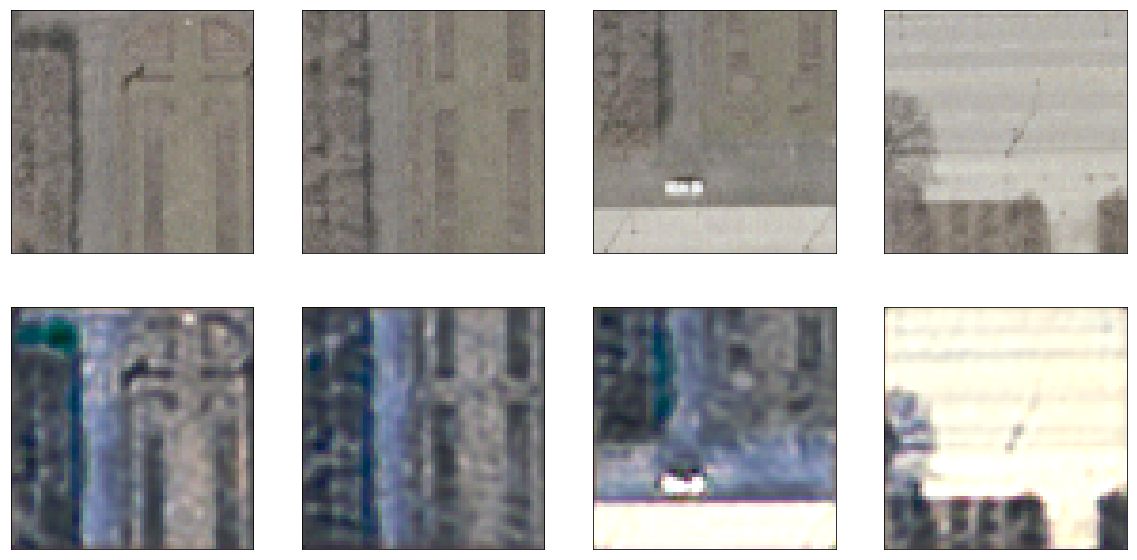

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
n0 (BatchNormalization)      (None, 64, 64, 3)         12        
_________________________________________________________________
c1 (Conv2D)                  (None, 64, 64, 64)        1792      
_________________________________________________________________
n1 (BatchNormalization)      (None, 64, 64, 64)        256       
_________________________________________________________________
c2 (Conv2D)                  (None, 64, 64, 64)        36928     
_________________________________________________________________
n2 (BatchNormalization)      (None, 64, 64, 64)        256       
_________________________________________________________________
c3 (Conv2D)                  (None, 64, 64, 32)        18464     
__________

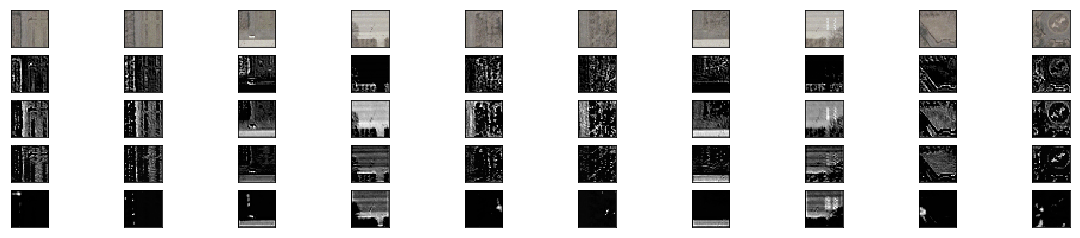

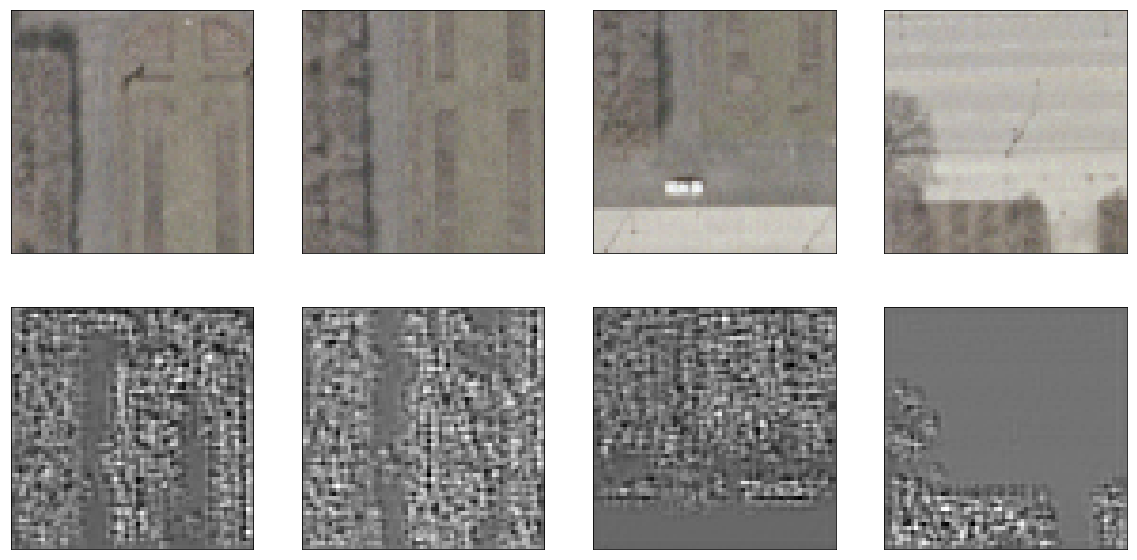

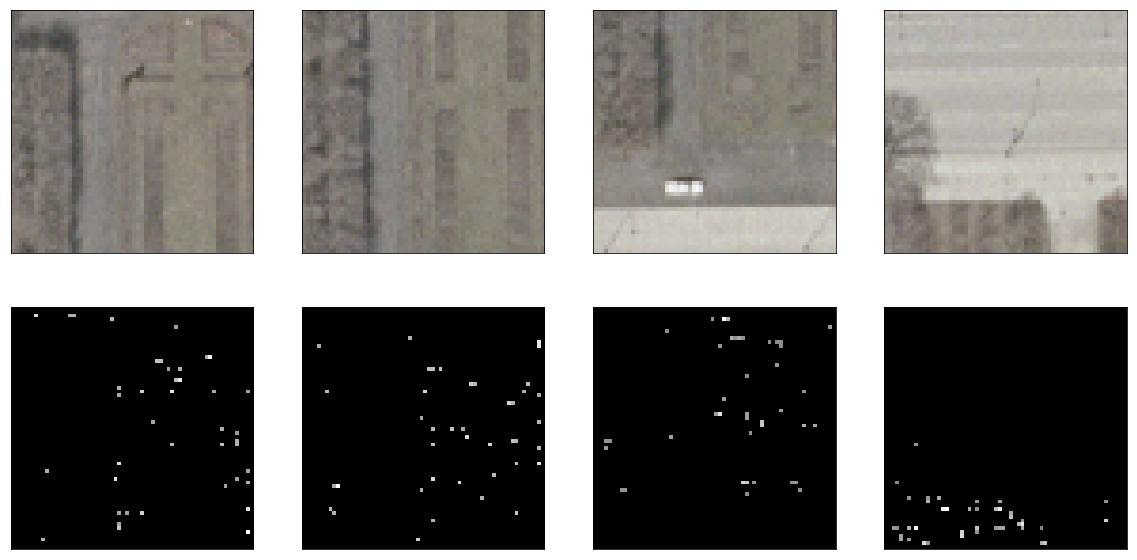

In [8]:
### plot

decoded_imgs = autoencoder.predict(test_batches)
show_imgs(test_batches,decoded_imgs)

print(autoencoder.summary())

autoencoder_show_hidden = Model(input_img, encoded)
encoded_imgs = autoencoder_show_hidden.predict(test_batches)

show_hidden(test_batches, encoded_imgs)

#print grads

show_imgs_gray_out(test_batches,out)

show_imgs_gray_out(test_batches,it_temp)


In [9]:
print(np.count_nonzero(out[0]==0)/size/size)

0.0


In [ ]:
a=len(encoded_imgs)
b=len(encoded_imgs[0])
c=len(encoded_imgs[0][0])

heatmap=np.zeros((a,b,c))

for i in range(a):
    for j in range(b):
        for k in range(c):
            #heatmap[i][j][k] = np.mean(abs(encoded_imgs[i][j][k]))
            heatmap[i][j][k] = np.max(encoded_imgs[i][j][k])

n=10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(test_batches[i].reshape(size,size,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    if decoded_imgs is not None:
        ax = plt.subplot(2, n, i+ 1 +n)
        plt.imshow(heatmap[i].reshape(int(size/2),int(size/2)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()



filtered_heat = np.zeros((a,b,c))

for i in range(a):
    q = np.percentile(heatmap[i],99)
    for j in range(b):
        for k in range(c):
            if(heatmap[i][j][k]>q):
                filtered_heat[i][j][k]=heatmap[i][j][k]
                
n=10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(test_batches[i].reshape(size,size,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    if decoded_imgs is not None:
        ax = plt.subplot(2, n, i+ 1 +n)
        plt.imshow(heatmap[i].reshape(int(size/2),int(size/2)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

In [3]:
import numpy as np

a=np.arange(1000).reshape(10,10,10)
#print(a)

b=a[2:8,2:8,2:8]
print(b)

[[[222 223 224 225 226 227]
  [232 233 234 235 236 237]
  [242 243 244 245 246 247]
  [252 253 254 255 256 257]
  [262 263 264 265 266 267]
  [272 273 274 275 276 277]]

 [[322 323 324 325 326 327]
  [332 333 334 335 336 337]
  [342 343 344 345 346 347]
  [352 353 354 355 356 357]
  [362 363 364 365 366 367]
  [372 373 374 375 376 377]]

 [[422 423 424 425 426 427]
  [432 433 434 435 436 437]
  [442 443 444 445 446 447]
  [452 453 454 455 456 457]
  [462 463 464 465 466 467]
  [472 473 474 475 476 477]]

 [[522 523 524 525 526 527]
  [532 533 534 535 536 537]
  [542 543 544 545 546 547]
  [552 553 554 555 556 557]
  [562 563 564 565 566 567]
  [572 573 574 575 576 577]]

 [[622 623 624 625 626 627]
  [632 633 634 635 636 637]
  [642 643 644 645 646 647]
  [652 653 654 655 656 657]
  [662 663 664 665 666 667]
  [672 673 674 675 676 677]]

 [[722 723 724 725 726 727]
  [732 733 734 735 736 737]
  [742 743 744 745 746 747]
  [752 753 754 755 756 757]
  [762 763 764 765 766 767]
  [772 773